# Bayesian regime-switching GARCH


References
* Murphy, Kevin, and Stuart Russell. "Rao-Blackwellised particle filtering for dynamic Bayesian networks." Sequential Monte Carlo methods in practice. New York, NY: Springer New York, 2001. 499-515.
* Duran-Martin, Gerardo, et al. "BONE: a unifying framework for Bayesian online learning in non-stationary environments." arXiv preprint arXiv:2411.10153 (2024).

In [1]:
import jax
import chex
import einops
import distrax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [3]:
plt.rcParams["text.usetex"] = True

## Model definitions

In [4]:
def draw_state(state, key, config):
    """
    Simulate one step of a system that evolves as
        sigma(t) = omega[k] + alpha[k] * y(t-1) + beta[k] * sigma(t-1)
        y(t) = sigma(t) * eps
    where eps ~ N(0,1)
    """
    key_regime, key_noise = jax.random.split(key)

    probabilities = config.transition_matrix[state.regime, :]
    logits = jnp.log(probabilities)
    regime_new = jax.random.categorical(key_regime, logits)

    eps = jax.random.normal(key_noise)

    omega = config.baseline_level[regime_new]
    alpha = config.shock_level[regime_new]
    beta = config.memory_level[regime_new]

    sigma2_new = omega + alpha * state.obs ** 2 + beta * state.sigma2
    obs_new = jnp.sqrt(sigma2_new) * eps

    state_new = state.replace(
        sigma2=sigma2_new,
        obs=obs_new,
        regime=regime_new
    )

    return state_new, state_new


@chex.dataclass
class SSMConfig:
    baseline_level: jax.Array # omega
    shock_level: jax.Array # alpha
    memory_level: jax.Array # beta
    transition_matrix: jax.Array # Regime transition matrix


@chex.dataclass
class VolState:
    sigma2: float
    obs: float
    regime: int

In [92]:
p_remain = 0.98
n_regimes = 2
transition_matrix = jnp.ones((n_regimes, n_regimes)) * (1 - p_remain) / (n_regimes - 1)
transition_matrix = transition_matrix.at[jnp.diag_indices(n_regimes)].set(p_remain)

transition_matrix = jnp.array([
    [0.99, 0.01],
    [0.05, 0.95]
])

baseline_level = jnp.array([0.0001, 0.0001]) # omega
shock_level = jnp.array([0.05, 0.8]) # alpha
memory_level = jnp.array([0.1, 0.1]) # beta

baseline_level = jnp.array([0.0001, 0.0008])
shock_level = jnp.array([0.05, 0.2])
memory_level = jnp.array([0.93, 0.75])

config = SSMConfig(
    baseline_level=baseline_level,
    shock_level=shock_level,
    memory_level=memory_level,
    transition_matrix=transition_matrix
)

In [93]:
sigma_inf = baseline_level / (1 - shock_level - memory_level) # limiting steady-state
jnp.sqrt(sigma_inf)

Array([0.07071071, 0.12649108], dtype=float32)

In [94]:
key = jax.random.PRNGKey(314)

n_steps = 365 * 2
keys = jax.random.split(key, n_steps)
_step = partial(draw_state, config=config)

regime_init = 0
state_init = VolState(sigma2=sigma_inf[regime_init], obs=0.0, regime=regime_init)

_, hist = jax.lax.scan(_step, state_init, keys)

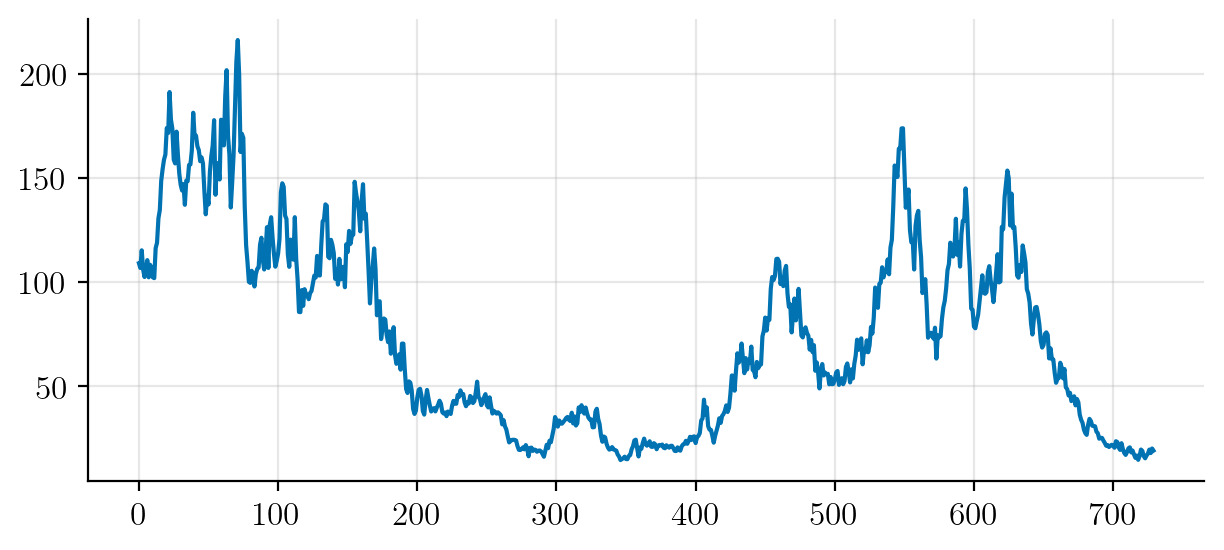

In [95]:
plt.plot(100 * jnp.exp(jnp.cumsum(hist.obs)))
plt.grid(alpha=0.3)

Text(0.5, 0.98, 'GARCH(1,1)')

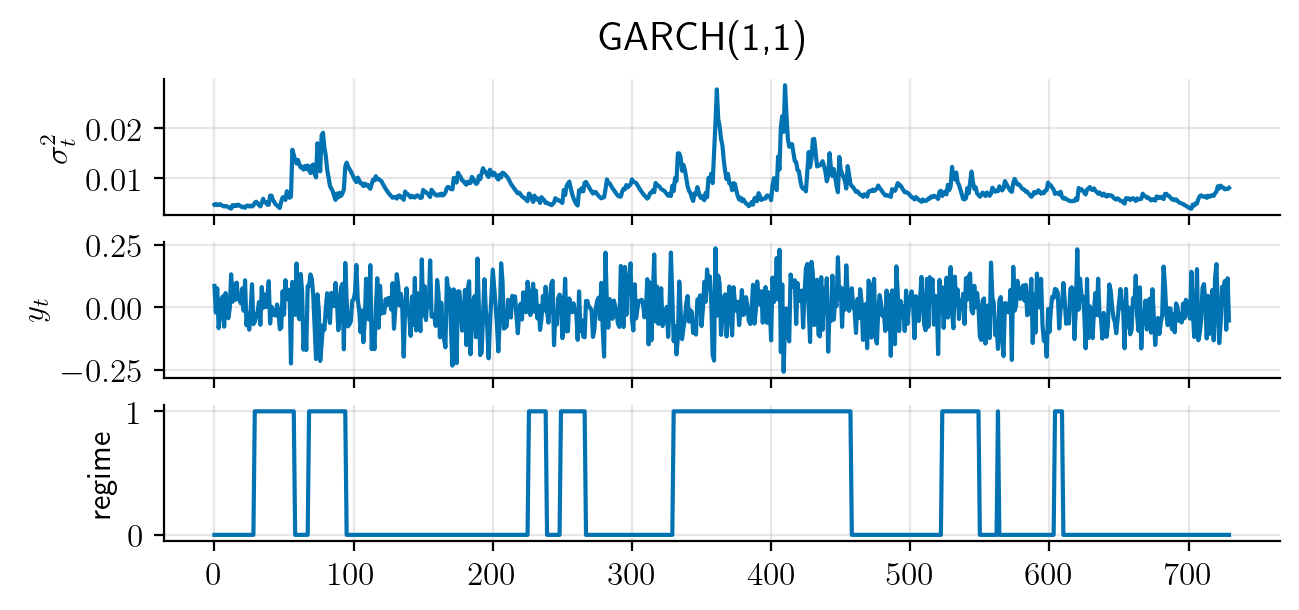

In [96]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(hist.sigma2)
axs[0].set_ylabel(r"$\sigma_t^2$")
axs[0].grid(alpha=0.3)

axs[1].plot(hist.obs)
axs[1].set_ylabel(r"$y_t$")
axs[1].grid(alpha=0.3)

axs[2].plot(hist.regime)
axs[2].set_ylabel("regime")
axs[2].grid(alpha=0.3)

plt.suptitle("GARCH(1,1)")

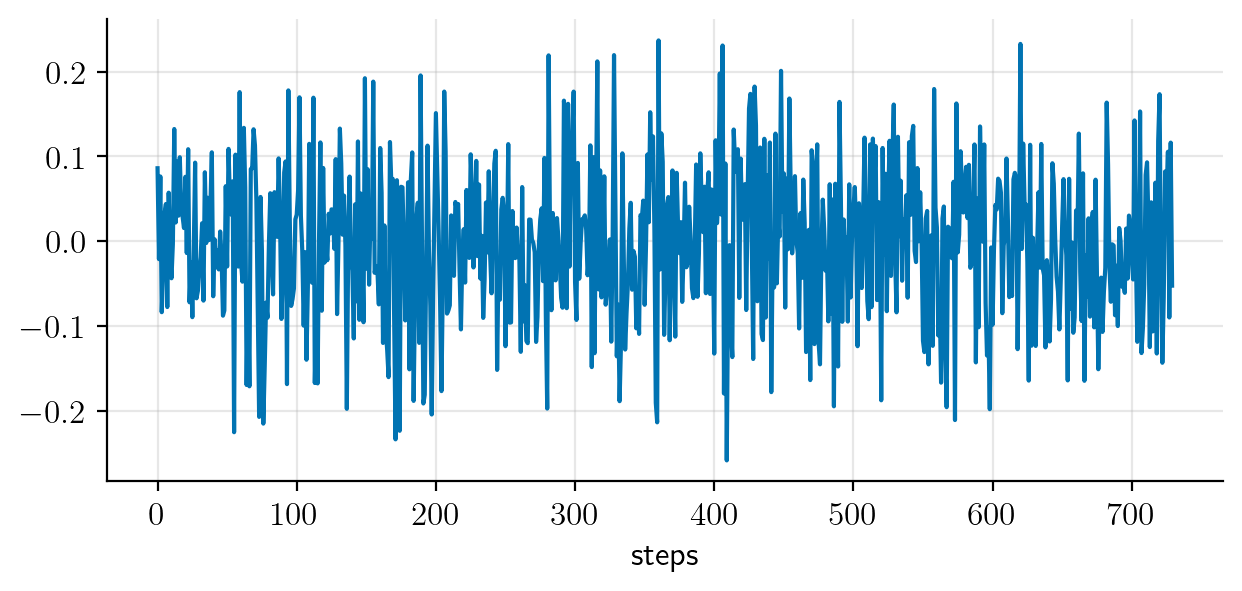

In [97]:
plt.plot(hist.obs)
plt.grid(alpha=0.3)
plt.xlabel("steps");

We are interested in recursively forecasting and updating our beliefs of model parameters
$$
    p(\sigma_t^2 \vert y_{1:t}) \propto p(\sigma_t^2 \vert y_{1:t-1})\,p(y_t \vert \sigma_2)
$$

Having spend some time in finance, I know finance bros don't like "overly complicated" maths, so I'll keep it as simple as possible and use my favourite tool: filtering and linearisation.

We might believe that, in reality, there is a latent variable which tells us in which regime we are in.
We seek to find this value in a recursive, online manner, rather than offline.
